# **Keras implementation of the proposed model**
This note implements the fully NN based model with self-inhibiting Hawkes process.

# **Import Modules**

In [1]:
!pip install numpy==1.19
!pip install tensorflow==2.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 27.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.0 which is incompatible.
tensorflow 2.9.2 requires numpy>=1.20, but you have numpy 1.19.0 which is incompatible.
jaxlib 0.3.22+cuda11.cudnn805 requires numpy>=1.20, but you have numpy 1.19.0 which is incompatible.
jax 0.3.23 requires numpy>=1.20, but you have numpy 1.19.0 which is incompatible.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.19.0 which is incompatible.
cmdstanpy 1.0.8 requires numpy>=1.21, but you have nump

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 421.8 MB 25 kB/s 
     |████████████████████████████████| 50 kB 8.6 MB/s 
     |████████████████████████████████| 3.8 MB 66.7 MB/s 
     |████████████████████████████████| 448 kB 73.9 MB/s 
     |████████████████████████████████| 26.1 MB 1.4 MB/s 
     |████████████████████████████████| 152 kB 58.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=bccf7abce94cd4f2e47200f8cd81ef43393979cd25ea887cb7251f21d9644345
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: cachetools
    Found existing installation: cachetools 5.2.0
    Uninstalling cachetools-5.2.0:
      Successfully uninstalled cachetools-5.2.0
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.14.1
    Uninstalling google

In [1]:
import numpy as np

################################### for neural network modeling
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import matplotlib
from matplotlib import pyplot as plt
import random
import pickle
from scipy import stats
print(tf.__version__)
print(np.__version__)
# numpy==1.19
# tensorflow==2.1
# scipy==1.4.1

2.1.0
1.19.0


# **Generate synthetic data**

Code to generate self-inhibiting Hawkes process with ReLU transfer function.

In [2]:
class exp_thinning_hawkes(object):
    def __init__(self, lambda_0, alpha, beta, t=0, max_jumps=None, max_time=None):
        """
        Parameters
        ----------
        lambda_0 : float
            Baseline constant intensity.
        alpha : float
            Interaction factor.
        beta : float
            Decay factor.
        t : float, optional
            Initial time. The default is 0.
        max_jumps : float, optional
            Maximal number of jumps. The default is None.
        max_time : float, optional
            Maximal time horizon. The default is None.
            
        Attributes
        ----------
        t_0 : float
            Initial time provided at initialization.
        timestamps : list of float
            List of simulated events. It includes the initial time t_0.
        intensity_jumps : list of float
            List of intensity at each simulated jump. It includes the baseline intensity lambda_0.
        aux : float
            Parameter used in simulation.
        simulated : bool
            Parameter that marks if a process has been already been simulated, or if its event times have been initialized.
        """
        self.alpha = alpha
        self.beta = beta
        self.t_0 = t
        self.t = t
        self.lambda_0 = lambda_0
        self.max_jumps = max_jumps
        self.max_time = max_time
        self.timestamps = [t]
        self.intensity_jumps = [lambda_0]
        self.aux = 0
        self.simulated = False

    def simulate(self):
        if not self.simulated:
            if self.max_jumps is not None and self.max_time is None:
                self.simulate_jumps()
            elif self.max_time is not None and self.max_jumps is None:
                self.simulate_time()
            else:
                print("Either max_jumps or max_time must be given.")
            self.simulated = True

        else:
            print("Process already simulated")

    def simulate_jumps(self):
        flag = 0

        candidate_intensity = self.lambda_0

        while flag < self.max_jumps:

            upper_intensity = max(self.lambda_0, candidate_intensity)

            self.t += np.random.exponential(1 / upper_intensity)
            candidate_intensity = self.lambda_0 + self.aux * np.exp(-self.beta * (self.t - self.timestamps[-1]))

            if upper_intensity * np.random.uniform() <= candidate_intensity:
                self.timestamps += [self.t]
                self.intensity_jumps += [candidate_intensity + self.alpha]
                self.aux = candidate_intensity - self.lambda_0 + self.alpha
                flag += 1

        self.max_time = self.timestamps[-1]

    def simulate_time(self):
        flag = self.t < self.max_time

        while flag:
            upper_intensity = max(self.lambda_0,
                                  self.lambda_0 + self.aux * np.exp(-self.beta * (self.t - self.timestamps[-1])))

            self.t += np.random.exponential(1 / upper_intensity)
            candidate_intensity = self.lambda_0 + self.aux * np.exp(-self.beta * (self.t - self.timestamps[-1]))

            flag = self.t < self.max_time

            if upper_intensity * np.random.uniform() <= candidate_intensity and flag:
                self.timestamps += [self.t]
                self.intensity_jumps += [candidate_intensity + self.alpha]
                self.aux = self.aux * np.exp(-self.beta * (self.t - self.timestamps[-2])) + self.alpha

    def plot_intensity(self, ax=None, plot_N=True):
        if not self.simulated:
            print("Simulate first")

        else:
            if plot_N:
                if ax is None:
                    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
                elif isinstance(ax[0], matplotlib.axes.Axes):
                    ax1, ax2 = ax
                else:
                    return "ax must be a (2,1) axes"
            else:
                if ax is None:
                    fig, ax1 = plt.subplots()
                elif isinstance(ax, matplotlib.axes.Axes):
                    ax1 = ax
                else:
                    return "ax must be an instance of an axes"

            self.timestamps.append(self.max_time)

            times = np.array([self.timestamps[0], self.timestamps[1]])
            intensities = np.array([self.lambda_0, self.lambda_0])
            step = 0.01
            for i, lambda_k in enumerate(self.intensity_jumps):
                if i != 0:
                    T_k = self.timestamps[i]
                    nb_step = np.maximum(100, np.floor((self.timestamps[i + 1] - T_k) / step))
                    aux_times = np.linspace(T_k, self.timestamps[i + 1], int(nb_step))
                    times = np.append(times, aux_times)
                    intensities = np.append(intensities, self.lambda_0 + (lambda_k - self.lambda_0) * np.exp(
                        -self.beta * (aux_times - T_k)))

            ax1.plot([0, self.max_time], [0, 0], c='k', alpha=0.5)
            if self.alpha < 0:
                ax1.plot(times, intensities, label="Underlying intensity", c="#1f77b4")
            ax1.plot(times, np.maximum(intensities, 0), label="Conditional intensity", c='r')
            ax1.legend()
            ax1.grid()
            if plot_N:
                ax2.step(self.timestamps, np.append(np.arange(0, len(self.timestamps) - 1), len(self.timestamps) - 2),
                         where="post", label="$N(t)$")
                ax2.legend()
                ax2.grid()
            self.timestamps.pop()

    def set_time_intensity(self, timestamps):
        if not self.simulated:
            self.timestamps = timestamps
            self.max_time = timestamps[-1]

            intensities = [self.lambda_0]
            for k in range(1, len(timestamps)):
                intensities += [self.lambda_0 + (intensities[-1] - self.lambda_0) * np.exp(
                    -self.beta * (timestamps[k] - timestamps[k - 1])) + self.alpha]
            self.intensity_jumps = intensities
            self.simulated = True

        else:
            print("Already simulated")

    def compensator_transform(self, plot=None, exclude_values=0):
        if not self.simulated:
            print("Simulate first")

        else:

            T_k = self.timestamps[1]

            compensator_k = self.lambda_0 * (T_k - self.t_0)

            self.timestamps_transformed = [compensator_k]
            self.intervals_transformed = [compensator_k]

            for k in range(2, len(self.timestamps)):

                lambda_k = self.intensity_jumps[k-1]
                tau_star = self.timestamps[k] - self.timestamps[k - 1]

                if lambda_k >= 0:
                    C_k = lambda_k - self.lambda_0
                else:
                    C_k = -self.lambda_0
                    tau_star -= (np.log(-(lambda_k - self.lambda_0)) - np.log(self.lambda_0)) / self.beta

                compensator_k = self.lambda_0 * tau_star + (C_k / self.beta) * (1 - np.exp(-self.beta * tau_star))

                self.timestamps_transformed += [self.timestamps_transformed[-1] + compensator_k]
                self.intervals_transformed += [compensator_k]

            if plot is not None:
                stats.probplot(self.intervals_transformed[exclude_values:], dist=stats.expon, plot=plot)

Code to generate inhibiting Hawkes processes with softplus transfer function

In [3]:
class HawkesInhibGen(object):
    '''
    here is the sequence generator using Hawkes process with inhibition
    '''
    def __init__(self):
        np.random.seed(0)
        self.dim_process = 1
        self.lambda_0 = np.float32(1.0)
        self.alpha = np.float32(-0.8)
        self.beta = np.float32(1.0)
        self.name = 'HawkesInhibGen'

        self.intensity_tilde = np.copy(self.lambda_0)
        self.intensity = np.log(np.float32(1.0) + np.exp(self.intensity_tilde))

        self.intensity_tilde_ub = None
        self.intensity_ub = None

        self.one_seq = []
        self.intensities = []

        self.cnt_total_event = np.int32(len(self.one_seq))
    
    def load_pregen_data(self):
      with open("pregen_data.pkl", "rb") as pregen_data:
        self.one_seq = pickle.load(pregen_data)
      with open("pregen_intensities.pkl", "rb") as pregen_intensities:
        self.intensities = pickle.load(pregen_intensities)

    def soft_relu(self, x):
        return np.log(np.float32(1.0)+np.exp(x))

    def hard_relu(self, x):
        return np.float32(0.5) * (x + np.abs(x))

    def restart_sequence(self):
        self.intensity_tilde = np.copy(self.lambda_0)
        self.intensity = self.soft_relu(self.intensity_tilde)

        self.intensity_tilde_ub = None
        self.intensity_ub = None

        self.one_seq = []
        self.intensities = []
        self.cnt_total_event = np.int32(len(self.one_seq))

    def compute_intensity_given_past(self, time_current):
        self.intensity_tilde = np.copy(self.lambda_0)
        for event in self.one_seq:
            time_since_start = event
            change_time = time_current - time_since_start
            decay_frac = np.exp(-self.beta * change_time)
            self.intensity_tilde += np.copy(self.alpha * decay_frac)
        self.intensity = self.soft_relu(self.intensity_tilde)

    def compute_intensity_upper_bound(self, time_current):
        self.intensity_tilde_ub = np.copy(self.lambda_0)
        for event in self.one_seq:
            time_since_start = event
            change_time = time_current - time_since_start
            decay_frac = np.exp(-self.beta * change_time)
            self.intensity_tilde_ub += np.copy(self.hard_relu(self.alpha) * decay_frac)
        self.intensity_ub = self.soft_relu(self.intensity_tilde_ub)
    
    def sample_time(self):
        time_current = np.float32(0.0)
        if len(self.one_seq) > 0:
            time_current = self.one_seq[-1]
        self.compute_intensity_upper_bound(time_current)
        intensity_hazard = np.sum(self.intensity_ub)
        u = 1.5
        while u >= 1.0:
            E = np.random.exponential(scale=1.0, size=None)
            U = np.random.uniform(low=0.0, high=1.0, size=None)
            time_current += ( E / intensity_hazard )
            self.compute_intensity_given_past(time_current)
            u = U * intensity_hazard / np.sum(self.intensity)
        return time_current

    def sample_one_event(self):
        time_since_start_new = self.sample_time()
        self.compute_intensity_given_past(time_since_start_new)
        prob = self.intensity / np.sum(self.intensity)
        return time_since_start_new

    def gen_one_seq(self, max_len):
        time_since_start = np.float32(0.0)
        idx_event = len(self.one_seq)
        print(idx_event)
        while idx_event < max_len:
            time_since_start_new = self.sample_one_event()
            self.cnt_total_event += 1
            time_since_start = time_since_start_new
            self.one_seq.append(time_since_start)
            self.intensities.append(self.intensity)
            if idx_event % 100 == 0 or idx_event + 1 == max_len:
              print(idx_event)
              print("saving")
              with open("pregen_data.pkl", "wb") as pregen_data:
                pickle.dump(self.one_seq, pregen_data)
              with open("pregen_intensities.pkl", "wb") as pregen_intensities:
                pickle.dump(self.intensities, pregen_intensities)
            idx_event += 1


# **Implementation of the proposed model**

The following keras model receives the event history and the elapsed time from the most recent event and outputs the hazard function and the cumulative hazard function.

In [4]:
class PreTrainModel:
  def __init__(self, T_train, T_test, intensities):
    self.T_train = T_train
    self.T_test = T_test
    self.idx = len(T_train)
    self.dT_train = np.ediff1d(T_train)
    self.intensities = intensities

    self.time_step = 20
    size_rnn = 64
    size_nn = 64
    size_layer_chfn = 2

    ## mean and std of the log of the inter-event interval, which will be used for the data standardization
    mu = np.log(self.dT_train).mean()
    sigma = np.log(self.dT_train).std()

    ## kernel initializer for positive weights
    def abs_glorot_uniform(shape, dtype=None, partition_info=None): 
        return K.abs(keras.initializers.glorot_uniform(seed=None)(shape, dtype=dtype))

    ## Inputs 
    event_history  = layers.Input(shape=(self.time_step, 1)) # input to RNN (event history)
    elapsed_time = layers.Input(shape=(1,)) # input to cumulative hazard function network (the elapsed time from the most recent event)

    ## log-transformation and standardization
    event_history_nmlz = layers.Lambda(lambda x: (K.log(x)-mu)/sigma)(event_history)
    elapsed_time_nmlz = layers.Lambda(lambda x: (K.log(x)-mu)/sigma)(elapsed_time) 

    ## RNN
    output_rnn = layers.SimpleRNN(size_rnn, input_shape=(self.time_step,1), activation='tanh')(event_history_nmlz)

    ## the first hidden layer in the cummulative hazard function network
    hidden_tau = layers.Dense(size_nn, kernel_initializer=abs_glorot_uniform, kernel_constraint=keras.constraints.NonNeg(), use_bias=False)(elapsed_time_nmlz) # elapsed time -> the 1st hidden layer, positive weights
    hidden_rnn = layers.Dense(size_nn)(output_rnn) # rnn output -> the 1st hidden layer
    hidden = layers.Lambda(lambda inputs: K.tanh(inputs[0] + inputs[1]))([hidden_tau,hidden_rnn])

    ## the second and higher hidden layers
    for i in range(size_layer_chfn-1):
        hidden = layers.Dense(size_nn,activation='tanh', kernel_initializer=abs_glorot_uniform, kernel_constraint=keras.constraints.NonNeg())(hidden) # positive weights

    ## Outputs
    Int_l = layers.Dense(1, activation='softplus', kernel_initializer=abs_glorot_uniform, kernel_constraint=keras.constraints.NonNeg())(hidden) # cumulative hazard function, positive weights
    l = layers.Lambda( lambda inputs: K.gradients(inputs[0], inputs[1])[0] )([Int_l, elapsed_time]) # hazard function

    ## define model
    self.model = Model(inputs=[event_history, elapsed_time],outputs=[l, Int_l])
    self.model.add_loss(- K.mean(K.log(1e-10 + l) - Int_l))
  
  def train(self):
    n = self.dT_train.shape[0]
    input_RNN = np.array( [ self.dT_train[i:i+self.time_step] for i in range(n-self.time_step) ]).reshape(n-self.time_step,self.time_step,1)
    input_CHFN = self.dT_train[-n+self.time_step:].reshape(n-self.time_step,1)
    self.model.compile(keras.optimizers.Adam(lr=0.0001))
    self.model.fit([input_RNN,input_CHFN],epochs=60,batch_size=256,validation_split=0.2)

  def test_intensity_numerical(self):
    dT_test = np.ediff1d(self.T_test)
    n = dT_test.shape[0]
    self.input_RNN_test = np.array(
        [dT_test[i:i + self.time_step] 
         for i in range(n-self.time_step)]
    ).reshape(n-self.time_step,self.time_step,1)
    self.input_CHFN_test = dT_test[-n+self.time_step:].reshape(n-self.time_step,1)

    [self.l_test,self.Int_l_test] = self.model.predict(
        [self.input_RNN_test, self.input_CHFN_test],
        batch_size=self.input_RNN_test.shape[0]
    )
    self.LL = np.log(self.l_test+1e-10) - self.Int_l_test
    print("With a loglikelihood of:", self.LL.sum())
    print("Mean negative log-likelihood per event: ", self.LL.mean())

  def test_intensity_graphical(self, end):
    fig1, ax1 = plt.subplots()
    ax1.plot(self.T_test[self.time_step:end + self.time_step], self.l_test[:end, 0], label="Predicted", c="#0000FF")
    ax1.plot(self.T_test[self.time_step:end + self.time_step], 
             self.intensities[self.idx + self.time_step:self.idx + end + self.time_step], label="Actual", c="#000000")

    ax1.legend()
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Intensity")

  def test_time_numerical(self):
    x_left = 1e-4  * np.mean(self.dT_train) * np.ones_like(self.input_CHFN_test)
    x_right = 100 * np.mean(self.dT_train) * np.ones_like(self.input_CHFN_test)

    for i in range(13):
        x_center = (x_left + x_right)/2
        v = self.model.predict([self.input_RNN_test, x_center], batch_size = x_center.shape[0])[1]
        x_left = np.where(v < np.log(2), x_center, x_left)
        x_right = np.where(v >= np.log(2), x_center, x_right)
        
    self.tau_pred = (x_left + x_right)/2
    AE = np.abs(self.input_CHFN_test - self.tau_pred)
    print("Mean absolute error: ", AE.mean())

  def test_time_graphical(self, end):
    pred_T_test = [self.T_test[self.time_step + 1]]
    pred_T_test += [self.T_test[i] + self.tau_pred[i - self.time_step - 1] for i in range(self.time_step + 1, end)]
    actual_T_test = self.T_test[self.time_step + 1 : end + 1]

    length = end - self.time_step
    start = self.idx + self.time_step * 2 + 1
    fig2, ax2 = plt.subplots()
    ax2.plot(pred_T_test, self.intensities[start:start + end - self.time_step], label="Predicted", c="#000000")
    ax2.plot(actual_T_test, self.intensities[start:start + end - self.time_step], label="Actual", c="#0000FF")

    ax2.legend()
    ax2.set_xlim(self.T_test[self.time_step + 1], max(pred_T_test[-1], actual_T_test[-1]))
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Intensity")

Generate 3 Hawkes processes

Self-exciting with lambda_0 = 1.0, alpha = 0.8, beta = 1.0

In [5]:
np.random.seed(0)
self_exciting = exp_thinning_hawkes(lambda_0 = 1.0, alpha = 0.8, beta = 1.0, max_jumps=60001)
self_exciting.simulate_jumps()
idx = int(60000*0.8)
self_exciting_model = PreTrainModel(
    T_train = self_exciting.timestamps[1:idx],
    T_test = self_exciting.timestamps[idx:],
    intensities = self_exciting.intensity_jumps
)

Inhibiting ReLU with lambda_0 = 1.0, alpha = -0.8, beta = 1.0

In [6]:
np.random.seed(0)
relu = exp_thinning_hawkes(lambda_0 = 1.0, alpha = -0.8, beta = 1.0, max_jumps=60001)
relu.simulate_jumps()
idx = int(60000*0.8)
relu_model = PreTrainModel(
    T_train = relu.timestamps[1:idx],
    T_test = relu.timestamps[idx:],
    intensities = relu.intensity_jumps
)

Inhibiting softplus with lambda_0 = 1.0, alpha = -0.8, beta = 1.0

In [9]:
softplus = HawkesInhibGen()
softplus.load_pregen_data()
max_len = 60000
softplus.gen_one_seq(max_len)
idx = int(60000 * 0.8)
softplus_model = PreTrainModel(
    T_train = softplus.one_seq[:idx],
    T_test = softplus.one_seq[idx:60000],
    intensities = softplus.intensities
)

60001


In [10]:
self_exciting_model.train()

Train on 38382 samples, validate on 9596 samples
Epoch 1/60
38382/38382 [==============================] - 2s 65us/sample - loss: 1.1729 - val_loss: 0.7005
Epoch 2/60
38382/38382 [==============================] - 2s 41us/sample - loss: 0.0819 - val_loss: -0.2927
Epoch 3/60
38382/38382 [==============================] - 2s 41us/sample - loss: -0.4293 - val_loss: -0.3290
Epoch 4/60
38382/38382 [==============================] - 2s 40us/sample - loss: -0.4395 - val_loss: -0.3282
Epoch 5/60
38382/38382 [==============================] - 2s 41us/sample - loss: -0.4424 - val_loss: -0.3360
Epoch 6/60
38382/38382 [==============================] - 2s 41us/sample - loss: -0.4439 - val_loss: -0.3359
Epoch 7/60
38382/38382 [==============================] - 2s 39us/sample - loss: -0.4471 - val_loss: -0.3375
Epoch 8/60
38382/38382 [==============================] - 2s 41us/sample - loss: -0.4483 - val_loss: -0.3379
Epoch 9/60
38382/38382 [==============================] - 2s 40us/sample - loss: -

With a loglikelihood of: 4107.164
Mean negative log-likelihood per event:  0.34280646


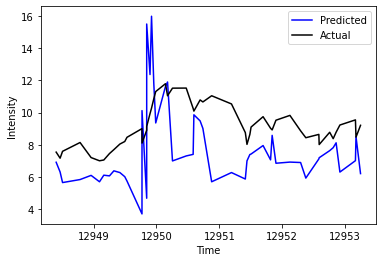

In [11]:
self_exciting_model.test_intensity_numerical()
self_exciting_model.test_intensity_graphical(50)

Mean absolute error:  0.21211626312629348


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


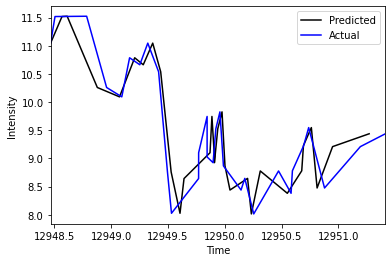

In [12]:
self_exciting_model.test_time_numerical()
self_exciting_model.test_time_graphical(50)

In [13]:
relu_model.train()

Train on 38382 samples, validate on 9596 samples
Epoch 1/60
38382/38382 [==============================] - 3s 69us/sample - loss: 3.1256 - val_loss: 2.6096
Epoch 2/60
38382/38382 [==============================] - 2s 42us/sample - loss: 2.2630 - val_loss: 1.8997
Epoch 3/60
38382/38382 [==============================] - 2s 43us/sample - loss: 1.6294 - val_loss: 1.4703
Epoch 4/60
38382/38382 [==============================] - 2s 41us/sample - loss: 1.4659 - val_loss: 1.4439
Epoch 5/60
38382/38382 [==============================] - 2s 40us/sample - loss: 1.4540 - val_loss: 1.4412
Epoch 6/60
38382/38382 [==============================] - 2s 42us/sample - loss: 1.4511 - val_loss: 1.4380
Epoch 7/60
38382/38382 [==============================] - 3s 65us/sample - loss: 1.4494 - val_loss: 1.4370
Epoch 8/60
38382/38382 [==============================] - 3s 66us/sample - loss: 1.4490 - val_loss: 1.4363
Epoch 9/60
38382/38382 [==============================] - 2s 42us/sample - loss: 1.4481 - val_l

With a loglikelihood of: -16924.273
Mean negative log-likelihood per event:  -1.4125928


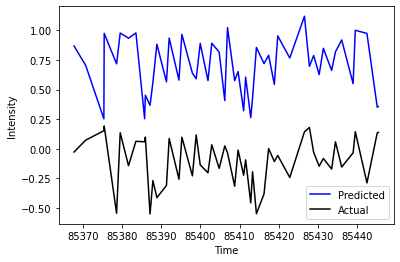

In [14]:
relu_model.test_intensity_numerical()
relu_model.test_intensity_graphical(50)

Mean absolute error:  0.8689490827355392


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


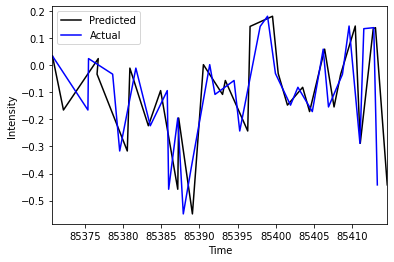

In [15]:
relu_model.test_time_numerical()
relu_model.test_time_graphical(50)

In [16]:
softplus_model.train()

Train on 38383 samples, validate on 9596 samples
Epoch 1/60
38383/38383 [==============================] - 2s 64us/sample - loss: 2.4418 - val_loss: 1.9920
Epoch 2/60
38383/38383 [==============================] - 2s 42us/sample - loss: 1.7259 - val_loss: 1.5015
Epoch 3/60
38383/38383 [==============================] - 2s 43us/sample - loss: 1.3182 - val_loss: 1.1893
Epoch 4/60
38383/38383 [==============================] - 2s 41us/sample - loss: 1.1752 - val_loss: 1.1701
Epoch 5/60
38383/38383 [==============================] - 2s 43us/sample - loss: 1.1670 - val_loss: 1.1637
Epoch 6/60
38383/38383 [==============================] - 2s 44us/sample - loss: 1.1622 - val_loss: 1.1620
Epoch 7/60
38383/38383 [==============================] - 2s 42us/sample - loss: 1.1589 - val_loss: 1.1556
Epoch 8/60
38383/38383 [==============================] - 2s 43us/sample - loss: 1.1526 - val_loss: 1.1478
Epoch 9/60
38383/38383 [==============================] - 2s 43us/sample - loss: 1.1401 - val_l

With a loglikelihood of: -13044.114
Mean negative log-likelihood per event:  -1.0889151


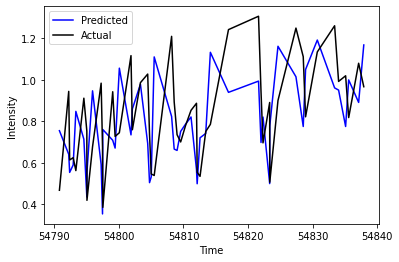

In [17]:
softplus_model.test_intensity_numerical()
softplus_model.test_intensity_graphical(50)

Mean absolute error:  0.681773255639548


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


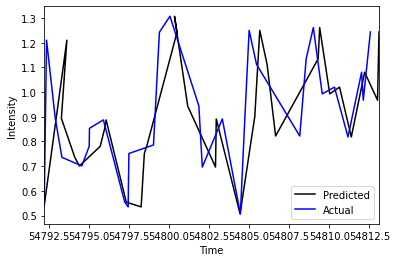

In [18]:
softplus_model.test_time_numerical()
softplus_model.test_time_graphical(50)